In [1]:
import warnings
warnings.filterwarnings("ignore")

import glob

from osgeo import gdal
from shapely import wkt

%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import rasterio
from torch.utils.tensorboard import SummaryWriter
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union
import solaris as sol

from tqdm import tqdm
import tifffile as sktif

import geopandas as gpd
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *
import ujson as json
from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


W1110 22:15:24.153236 139671821543232 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/metrics.py:103: The name tf.keras.metrics.cosine_proximity is deprecated. Please use tf.keras.losses.cosine_similarity instead.

W1110 22:15:24.195799 139671821543232 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/_keras_losses.py:104: The name tf.keras.losses.cosine is deprecated. Please use tf.keras.losses.cosine_similarity instead.



In [2]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"

train_images_crops = data_dir/"train_crops"
train_mask_crops = data_dir/"mask_crops"

In [3]:
train_images_crops.ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_hurricane-harvey_00000406_pre_disaster._8.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_mexico-earthquake_00000034_pre_disaster._6.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_hurricane-michael_00000454_pre_disaster._7.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_midwest-flooding_00000033_pre_disaster._0.png'),
 PosixPath('/media/wwymak/Storage/xView2/train_crops/rgb_hurricane-harvey_00000015_pre_disaster._1.png')]

In [4]:
unique_img_ids = list(set([x.name.replace('rgb_', '').split('.')[0] for x in train_images_crops.ls() ]))

In [5]:
unique_img_ids[:5]

['socal-fire_00001134_pre_disaster',
 'santa-rosa-wildfire_00000119_pre_disaster',
 'hurricane-florence_00000449_pre_disaster',
 'hurricane-matthew_00000285_pre_disaster',
 'hurricane-matthew_00000373_pre_disaster']

In [6]:
np.random.seed(42)
np.random.shuffle(unique_img_ids)
train_ids = unique_img_ids[:int(0.8 * len(unique_img_ids))]
valid_ids = unique_img_ids[int(0.8 * len(unique_img_ids)):]

In [7]:
def is_valid_func(fname):
    img_id = '_'.join(Path(fname).name.split('_')[1:3])

    return img_id in valid_ids

def get_mask_fn(fname):
    return train_mask_crops / fname.name.replace("rgb", "mask")

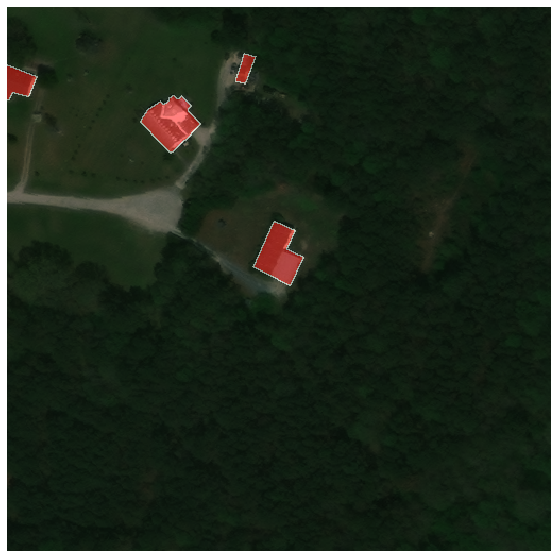

In [8]:
# test that masks are opening correctly with open_mask() settings
img_f = train_images_crops.ls()[100]
img = open_image(img_f)
mask = open_mask(get_mask_fn(img_f), convert_mode='RGB', div=False)

fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        inputs = inputs.float()
        targets = targets.float()
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        
class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
    @staticmethod   
    def dice_loss(input, target):
        input = input.float()
        target = target.float()
        smooth = 1.
        input = torch.sigmoid(input)
        iflat = input.contiguous().view(-1).float()
        tflat = target.contiguous().view(-1).float()
        intersection = (iflat * tflat).sum()
        return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth))
        
    def forward(self, input, target):
        loss = self.dice_loss(input, target)
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

In [10]:
class MultichannelLoss(nn.Module):
    def __init__(self, reduction='mean', loss_funcs=[FocalLoss(), DiceLoss()], loss_weights=[0.8,0.2], channel_weights=[1,1,1]):
        super().__init__()
        self.reduction = reduction
        self.loss_funcs = loss_funcs
        self.loss_weights = loss_weights
        self.channel_weights = channel_weights
        
    def forward(self, output, target):
        total_loss = 0
        for loss_func in self.loss_funcs:
            loss_func.reduction = self.reduction
        num_channels = output.shape[1]
        for channel_weight, channel in zip(self.channel_weights, range(num_channels)):
            channel_loss = 0
            for loss_weight, loss_f in zip(self.loss_weights, self.loss_funcs):
                channel_loss += loss_weight * loss_f(output[:, channel, None], target[:, channel, None])
            total_loss += channel_weight * channel_loss
        return total_loss / sum(self.channel_weights)


In [11]:
def acc_thresh_multich(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True, one_ch:int=None)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        target = target[:,one_ch,None]
    
    input = input.view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

def dice_multich(input:Tensor, targs:Tensor, iou:bool=False, one_ch:int=None)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
#     pdb.set_trace()
    n = targs.shape[0]
    input = input.sigmoid()
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        targs = targs[:,one_ch,None]
    
    input = (input>0.5).view(n,-1).float()
    targs = targs.view(n,-1).float()

    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)
    
acc_ch0 = partial(acc_thresh_multich, one_ch=0)
dice_ch0 = partial(dice_multich, one_ch=0)
metrics = [acc_thresh_multich, dice_multich, acc_ch0, dice_ch0]

In [12]:
# def multichannel_dice(input:Tensor, targets:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
#     n = targets.shape[0]
# def dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
#     "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
#     n = targs.shape[0]
#     input = input.argmax(dim=1).view(n,-1)
#     targs = targs.view(n,-1)
#     intersect = (input * targs).sum(dim=1).float()
#     union = (input+targs).sum(dim=1).float()
#     if not iou: l = 2. * intersect / union
#     else: l = intersect / (union-intersect+eps)
#     l[union == 0.] = 1.
#     return l.mean()

In [13]:
# class SegLabelListCustom(SegmentationLabelList):
#     def open(self, fn): 
#         mask = open_mask(fn, div=True, convert_mode='RGB')
#         print(mask.shape, mask.data.max(), mask.data.min())
#         return mask
    
# class SegItemListCustom(SegmentationItemList):
#     _label_cls = SegLabelListCustom
codes = np.array(['Footprint', 'boundary', 'boundary2'])

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True, convert_mode='RGB')
    
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [14]:
size=256
bs=16
src = (SegItemListCustom.from_folder(train_images_crops)
#        .filter_by_func(lambda fname: '_pre_disaster' in Path(fname).name)
      .split_by_valid_func(is_valid_func)
       .label_from_func(get_mask_fn, classes=codes))

data = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [15]:
ImageSegment??

In [16]:
learn = unet_learner(data, models.resnet34, model_dir=data_dir/"models",
                     metrics=metrics, 
                     loss_func=MultichannelLoss(
                        reduction='mean',
                        loss_funcs=[FocalLoss(gamma=1, alpha=0.95),
                                    DiceLoss(),
                                   ], 
                        loss_weights=[0.8,0.2],
                        channel_weights=[1,1,1])
                    )

In [17]:
learn.lr_find()

RuntimeError: CUDA error: device-side assert triggered

In [18]:
open_mask??